# Import libraries

In [1]:
import re
import nltk
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from nltk.corpus import stopwords
stopwords = stopwords.words('english')

# Import datasets

In [2]:
train = pd.read_excel('/kaggle/input/Data_Train.xlsx')
test = pd.read_excel('/kaggle/input/Data_Test.xlsx')

In [3]:
train.shape, test.shape

((6237, 9), (1560, 8))

# Data exploration

In [4]:
train.duplicated().sum(), test.duplicated().sum()

(0, 8)

In [5]:
train.head()

,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory,Price
0,The Prisoner's Gold (The Hunters 3),Chris Kuzneski,"Paperback,– 10 Mar 2016",4.0 out of 5 stars,8 customer reviews,THE HUNTERS return in their third brilliant no...,Action & Adventure (Books),Action & Adventure,220.00
1,Guru Dutt: A Tragedy in Three Acts,Arun Khopkar,"Paperback,– 7 Nov 2012",3.9 out of 5 stars,14 customer reviews,A layered portrait of a troubled genius for wh...,Cinema & Broadcast (Books),"Biographies, Diaries & True Accounts",202.93
2,Leviathan (Penguin Classics),Thomas Hobbes,"Paperback,– 25 Feb 1982",4.8 out of 5 stars,6 customer reviews,"""During the time men live without a common Pow...",International Relations,Humour,299.00
3,A Pocket Full of Rye (Miss Marple),Agatha Christie,"Paperback,– 5 Oct 2017",4.1 out of 5 stars,13 customer reviews,A handful of grain is found in the pocket of a...,Contemporary Fiction (Books),"Crime, Thriller & Mystery",180.00
4,LIFE 70 Years of Extraordinary Photography,Editors of Life,"Hardcover,– 10 Oct 2006",5.0 out of 5 stars,1 customer review,"For seven decades, ""Life"" has been thrilling t...",Photography Textbooks,"Arts, Film & Photography",965.62


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6237 entries, 0 to 6236
Data columns (total 9 columns):
Title           6237 non-null object
Author          6237 non-null object
Edition         6237 non-null object
Reviews         6237 non-null object
Ratings         6237 non-null object
Synopsis        6237 non-null object
Genre           6237 non-null object
BookCategory    6237 non-null object
Price           6237 non-null float64
dtypes: float64(1), object(8)
memory usage: 438.7+ KB


In [7]:
train.nunique()

Title           5568
Author          3679
Edition         3370
Reviews           36
Ratings          342
Synopsis        5549
Genre            345
BookCategory      11
Price           1614
dtype: int64

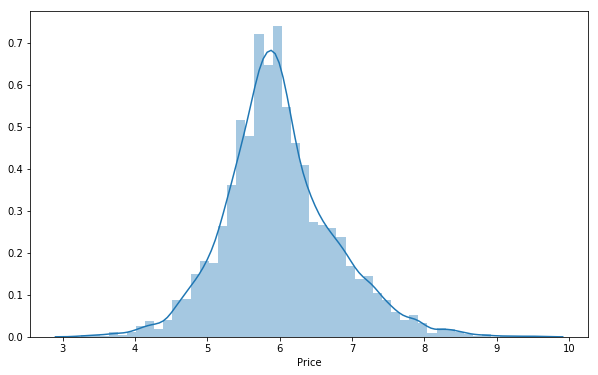

In [8]:
plt.figure(figsize=(10,6))
sns.distplot(np.log1p(train['Price']))

# Data pre-processing

In [9]:
train = train[train['Price'] < 10000].reset_index(drop=True)

In [10]:
df = train.append(test,ignore_index=True)
df.shape

(7794, 9)

In [11]:
df.columns = ['Author', 'BookCategory', 'Edition', 'Genre', 'Price', 'Reviews', 'Ratings', 'Synopsis', 'Title']

In [12]:
df.shape

(7794, 9)

In [13]:
df.head(2)

,Author,BookCategory,Edition,Genre,Price,Reviews,Ratings,Synopsis,Title
0,Chris Kuzneski,Action & Adventure,"Paperback,– 10 Mar 2016",Action & Adventure (Books),220.00,8 customer reviews,4.0 out of 5 stars,THE HUNTERS return in their third brilliant no...,The Prisoner's Gold (The Hunters 3)
1,Arun Khopkar,"Biographies, Diaries & True Accounts","Paperback,– 7 Nov 2012",Cinema & Broadcast (Books),202.93,14 customer reviews,3.9 out of 5 stars,A layered portrait of a troubled genius for wh...,Guru Dutt: A Tragedy in Three Acts


In [14]:
df['Title_1'] = df['Title'].str.extract(r"\((.*?)\)", expand=False) 
df['Title_1'] = df['Title_1'].fillna('missingTitle') 
df['Genre'] = df['Genre'].str.replace(r"\(.*\)","")
df['Reviews'] = df['Reviews'].str.replace(',','')
df['Reviews'] = df['Reviews'].str.split().str.get(0).astype(float)
df['Ratings'] = df['Ratings'].str.split().str.get(0).astype(float)
df['BookCategory_1'] = df['BookCategory'].str.split(',').str[0]
df['BookCategory_2'] = df['BookCategory'].str.split(',').str[1]
df['BookCategory_2'] = df['BookCategory_2'].fillna('missingBookCategory') 

In [15]:
df['Edition_1'] = df['Edition'].str.split(',').str[0]
df['Edition_2'] = df['Edition'].str.split(',').str[1]
df['Edition_2'] = df['Edition_2'].str.replace('– ','')
df['Edition_year'] = pd.to_datetime(df['Edition_2'], errors='coerce').dt.year
df['Edition_month'] = pd.to_datetime(df['Edition_2'], errors='coerce').dt.month
df['Edition_date'] = pd.to_datetime(df['Edition_2'], errors='coerce').dt.day

In [16]:
df.isnull().sum()

Author               0
BookCategory         0
Edition              0
Genre                0
Price             1560
Reviews              0
Ratings              0
Synopsis             0
Title                0
Title_1              0
BookCategory_1       0
BookCategory_2       0
Edition_1            0
Edition_2            0
Edition_year       992
Edition_month      992
Edition_date       992
dtype: int64

In [17]:
df.head(2)

,Author,BookCategory,Edition,Genre,Price,Reviews,Ratings,Synopsis,Title,Title_1,BookCategory_1,BookCategory_2,Edition_1,Edition_2,Edition_year,Edition_month,Edition_date
0,Chris Kuzneski,Action & Adventure,"Paperback,– 10 Mar 2016",Action & Adventure,220.00,8.0,4.0,THE HUNTERS return in their third brilliant no...,The Prisoner's Gold (The Hunters 3),The Hunters 3,Action & Adventure,missingBookCategory,Paperback,10 Mar 2016,2016.0,3.0,10.0
1,Arun Khopkar,"Biographies, Diaries & True Accounts","Paperback,– 7 Nov 2012",Cinema & Broadcast,202.93,14.0,3.9,A layered portrait of a troubled genius for wh...,Guru Dutt: A Tragedy in Three Acts,missingTitle,Biographies,Diaries & True Accounts,Paperback,7 Nov 2012,2012.0,11.0,7.0


In [18]:
agg_func = {
    'Reviews': ['mean','median','min','max','sum'],
    'Ratings': ['mean','median','min','max','sum']
}
agg_BookCategory_1 = df.groupby('BookCategory_1').agg(agg_func)
agg_BookCategory_1.columns = [ 'BookCategory_1_' + ('_'.join(col).strip()) for col in agg_BookCategory_1.columns.values]
agg_BookCategory_1.reset_index(inplace=True)
df = df.merge(agg_BookCategory_1, on=['BookCategory_1'], how='left')

In [19]:
agg_func = {
    'Reviews': ['mean','median','min','max','sum'],
    'Ratings': ['mean','median','min','max','sum']
    
}
agg_BookCategory_2 = df.groupby('BookCategory_2').agg(agg_func)
agg_BookCategory_2.columns = [ 'BookCategory_2_' + ('_'.join(col).strip()) for col in agg_BookCategory_2.columns.values]
agg_BookCategory_2.reset_index(inplace=True)
df = df.merge(agg_BookCategory_2, on=['BookCategory_2'], how='left')

In [20]:
agg_func = {
    'Reviews': ['mean','median','min','max','sum'],
    'Ratings': ['mean','median','min','max','sum']
}
agg_Author = df.groupby('Author').agg(agg_func)
agg_Author.columns = [ 'Author_' + ('_'.join(col).strip()) for col in agg_Author.columns.values]
agg_Author.reset_index(inplace=True)
df = df.merge(agg_Author, on=['Author'], how='left')

In [21]:
agg_func = {
    'Reviews': ['mean','median','min','max','sum'],
    'Ratings': ['mean','median','min','max','sum']
}
agg_Genre = df.groupby('Genre').agg(agg_func)
agg_Genre.columns = [ 'Genre_' + ('_'.join(col).strip()) for col in agg_Genre.columns.values]
agg_Genre.reset_index(inplace=True)
df = df.merge(agg_Genre, on=['Genre'], how='left')

In [22]:
agg_func = {
    'Reviews': ['mean','median','min','max','sum'],
    'Ratings': ['mean','median','min','max','sum']
}
agg_Title = df.groupby('Title').agg(agg_func)
agg_Title.columns = [ 'Title_' + ('_'.join(col).strip()) for col in agg_Title.columns.values]
agg_Title.reset_index(inplace=True)
df = df.merge(agg_Title, on=['Title'], how='left')

In [23]:
calc = df.groupby(['Title'], axis=0).agg({'Title':[('op1', 'count')]}).reset_index() 
calc.columns = ['Title','Title Count']
df = df.merge(calc, on=['Title'], how='left')

calc = df.groupby(['BookCategory_1'], axis=0).agg({'BookCategory_1':[('op1', 'count')]}).reset_index() 
calc.columns = ['BookCategory_1','BookCategory_1 Count']
df = df.merge(calc, on=['BookCategory_1'], how='left')

calc = df.groupby(['Edition_year'], axis=0).agg({'Edition_year':[('op1', 'count')]}).reset_index() 
calc.columns = ['Edition_year','Edition_year Count']
df = df.merge(calc, on=['Edition_year'], how='left')

calc = df.groupby(['Edition_month'], axis=0).agg({'Edition_month':[('op1', 'count')]}).reset_index() 
calc.columns = ['Edition_month','Edition_month Count']
df = df.merge(calc, on=['Edition_month'], how='left')

calc = df.groupby(['Edition_date'], axis=0).agg({'Edition_date':[('op1', 'count')]}).reset_index() 
calc.columns = ['Edition_date','Edition_date Count']
df = df.merge(calc, on=['Edition_date'], how='left')

In [24]:
df['Title_Synopsis'] = df['Title'] + ' ' + df['Synopsis'] + ' ' + df['Author']

In [25]:
from nltk.stem.wordnet import WordNetLemmatizer
lemma = WordNetLemmatizer()

In [26]:
# function for data cleaning and lemmatization
def clean_reviews(review_text, logging=False):
    counter = 1
    clean_text = []
    for texts in review_text:
        if counter % 1000 == 0 and logging:
            print("Processed %d records." % (counter))
        counter += 1
        texts = texts.lower()
        texts = re.sub(r'www.[^ ]+', ' ', texts)
        texts = re.sub(r'https?://[^ ]+', ' ', texts)
        texts = re.sub(r'https://[^ ]+', ' ', texts)
        texts = re.sub(r'[^a-z]', ' ', texts)
        tokens = nltk.word_tokenize(texts)
        tokens = [tok for tok in tokens if len(tok) > 2]
        tokens = [lemma.lemmatize(token, pos='n') for token in tokens]
        tokens = ' '.join(tokens)
        clean_text.append(tokens)
    return pd.Series(clean_text)

clean_text = clean_reviews(df['Title_Synopsis'], logging=True)
df['Title_Synopsis'] = clean_text

Processed 1000 records.
Processed 2000 records.
Processed 3000 records.
Processed 4000 records.
Processed 5000 records.
Processed 6000 records.
Processed 7000 records.


In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf1 = TfidfVectorizer(ngram_range=(1, 3), min_df=5, token_pattern=r'\w{3,}', max_features=15000)
df_title = tf1.fit_transform(df['Title_Synopsis'])
df_title = pd.DataFrame(data=df_title.toarray(), columns=tf1.get_feature_names())
df_title.shape

(7794, 15000)

In [28]:
df = pd.concat([df, df_title], axis=1) 
df.shape

(7794, 15073)

In [29]:
for col in ['BookCategory_1', 'BookCategory_2', 'Edition_1', 'Edition_2', 'Genre', 'Title_1']:
    df[col] = df[col].astype('category')

In [30]:
df.drop(['Synopsis','Title','BookCategory','Edition','Title_Synopsis','Author'], axis=1, inplace=True)

In [31]:
train_df = df[df['Price'].isnull()!=True]
test_df = df[df['Price'].isnull()==True]
test_df.drop(['Price'], axis=1, inplace=True)

In [32]:
train_df.shape, test_df.shape

((6234, 15067), (1560, 15066))

In [33]:
train_df['Price'] = np.log1p(train_df['Price'])

In [34]:
train_df.head(2)

,Genre,Price,Reviews,Ratings,Title_1,BookCategory_1,BookCategory_2,Edition_1,Edition_2,Edition_year,...,youtube,yuvraj,zen,zen pencil,zero,zlatan,zoe,zombie,zone,zoo
0,Action & Adventure,5.398163,8.0,4.0,The Hunters 3,Action & Adventure,missingBookCategory,Paperback,10 Mar 2016,2016.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Cinema & Broadcast,5.317777,14.0,3.9,missingTitle,Biographies,Diaries & True Accounts,Paperback,7 Nov 2012,2012.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Train test split

In [35]:
X = train_df.drop(labels=['Price'], axis=1)
y = train_df['Price'].values

from sklearn.model_selection import train_test_split
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.25, random_state=1)

In [36]:
X_train.shape, y_train.shape, X_cv.shape, y_cv.shape

((4675, 15066), (4675,), (1559, 15066), (1559,))

# Build the model

In [37]:
from math import sqrt 
from sklearn.metrics import mean_squared_log_error

## Light GBM

In [38]:
import lightgbm as lgb
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_cv, label=y_cv)

param = {'objective': 'regression',
         'boosting': 'gbdt',  
         'metric': 'l2_root',
         'learning_rate': 0.01, 
         'num_iterations': 3500,
         'num_leaves': 80,
         'max_depth': -1,
         'min_data_in_leaf': 11,
         'bagging_fraction': 0.80,
         'bagging_freq': 1,
         'bagging_seed': 3,
         'feature_fraction': 0.80,
         'feature_fraction_seed': 2,
         'early_stopping_round': 200,
         'max_bin': 250
         }

lgbm = lgb.train(params=param, verbose_eval=100, train_set=train_data, valid_sets=[test_data])

y_pred_lgbm = lgbm.predict(X_cv)
print('RMSLE:', sqrt(mean_squared_log_error(np.expm1(y_cv), np.expm1(y_pred_lgbm))))

Training until validation scores don't improve for 200 rounds.
[100]	valid_0's rmse: 0.592264
[200]	valid_0's rmse: 0.540034
[300]	valid_0's rmse: 0.516514
[400]	valid_0's rmse: 0.505113
[500]	valid_0's rmse: 0.4993
[600]	valid_0's rmse: 0.495693
[700]	valid_0's rmse: 0.493777
[800]	valid_0's rmse: 0.492454
[900]	valid_0's rmse: 0.491574
[1000]	valid_0's rmse: 0.49094
[1100]	valid_0's rmse: 0.490537
[1200]	valid_0's rmse: 0.490253
[1300]	valid_0's rmse: 0.489982
[1400]	valid_0's rmse: 0.489906
[1500]	valid_0's rmse: 0.489991
Early stopping, best iteration is:
[1395]	valid_0's rmse: 0.489883
RMSLE: 0.48988263234329854


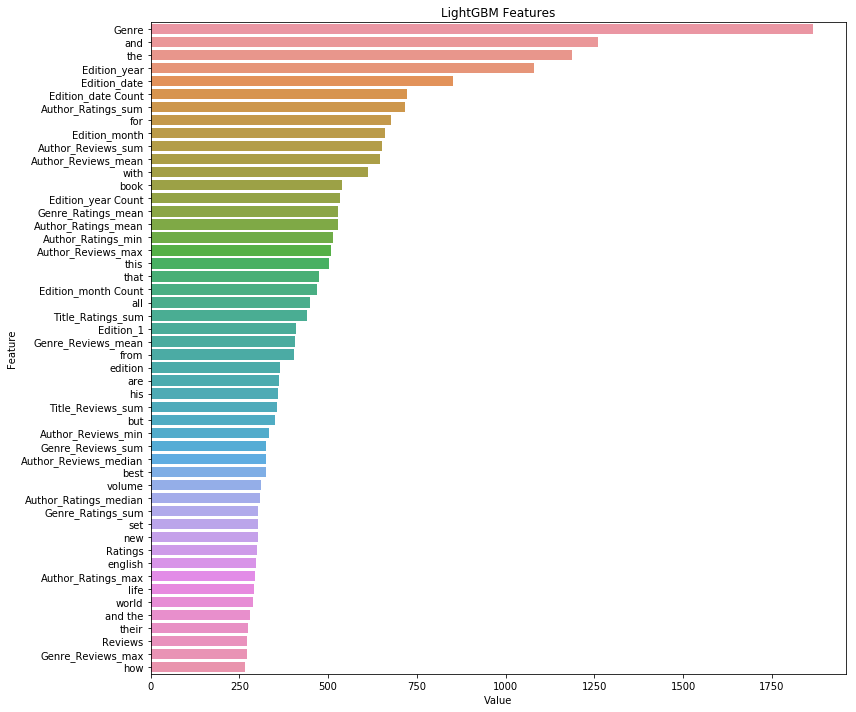

In [39]:
feature_imp = pd.DataFrame(sorted(zip(lgbm.feature_importance(), X.columns), reverse=True)[:50], 
                           columns=['Value','Feature'])
plt.figure(figsize=(12, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

# Predict on test set

In [40]:
Xtest = test_df

## Light GBM

In [41]:
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor

errlgb = []
y_pred_totlgb = []

fold = KFold(n_splits=15, shuffle=True, random_state=42)

for train_index, test_index in fold.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    lgbm = LGBMRegressor(**param)
    lgbm.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0, early_stopping_rounds=200)

    y_pred_lgbm = lgbm.predict(X_test)
    print("RMSLE LGBM: ", sqrt(mean_squared_log_error(np.exp(y_test), np.exp(y_pred_lgbm))))

    errlgb.append(sqrt(mean_squared_log_error(np.exp(y_test), np.exp(y_pred_lgbm))))
    p = lgbm.predict(Xtest)
    y_pred_totlgb.append(p)

RMSLE LGBM:  0.506805159891807
RMSLE LGBM:  0.5199233909005462
RMSLE LGBM:  0.4659871672717169
RMSLE LGBM:  0.4911263436689297
RMSLE LGBM:  0.46724096565585754
RMSLE LGBM:  0.5191538391630042
RMSLE LGBM:  0.4938260225649079
RMSLE LGBM:  0.44879425345451657
RMSLE LGBM:  0.48124013735215265
RMSLE LGBM:  0.4952685167881142
RMSLE LGBM:  0.4608456495305424
RMSLE LGBM:  0.47777782618372666
RMSLE LGBM:  0.45426087184453623
RMSLE LGBM:  0.4435527453055858
RMSLE LGBM:  0.5121057492831896


In [42]:
np.mean(errlgb,0)

0.4825272425906088

In [43]:
lgbm_final = np.expm1(np.mean(y_pred_totlgb,0))
lgbm_final

array([ 492.65620303, 1086.77556652,  348.27831085, ...,  311.96158651,
        431.38646782, 1083.09912878])

# Submission

In [44]:
df_sub = pd.DataFrame(data=lgbm_final, columns=['Price'])
writer = pd.ExcelWriter('Output.xlsx', engine='xlsxwriter')
df_sub.to_excel(writer,sheet_name='Sheet1', index=False)
writer.save()